In [1]:
import torch
import json
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Chapter 1 Introduction

Deep learning with supervised learning: </br> 

- Document classification: The target is a categorical label, and the observation is a document. </br>
- In machine translation: The observation is a sentence in a language, and the target is a sentence in another language. </br>

Sources:

- Dougherty et al (1995)

## Observations and target encoding

We will need to represent observations (text) numerically to use then in conjunction with machine learning algorithms. We will start with some simple count-based representation using fixed vectors. This representation are sparse matrix and vectors values results.

### One-Hot representation

Start with a zero vector and set as 1 the corresponding entry in the vector if the word is present in the sentence or the document.

In [2]:
corpus = ["Time flies like an arrow", "Fruit flies like a banana"]
# corpus = ["This is a a sample", "This is another another example example example"]

Tokenizing the corpus ignoring punctuation and Upper case words will yields to the following vocabulary, this is called **Basic Tokenization**

In [3]:
vocab = set(word.lower() for sentence in corpus for word in sentence.split())
vocab = list(vocab)
vocab.sort()
word2idx = dict((word, idx) for idx, word in enumerate(vocab))
idx2word = [word for word in vocab]
vocab_size = len(vocab)
print("vocab:", vocab)
print("word to index mapping:", word2idx)
print("index to word mapping:", idx2word)
print("Size of the vocabulary:", vocab_size)

vocab: ['a', 'an', 'arrow', 'banana', 'flies', 'fruit', 'like', 'time']
word to index mapping: {'a': 0, 'an': 1, 'arrow': 2, 'banana': 3, 'flies': 4, 'fruit': 5, 'like': 6, 'time': 7}
index to word mapping: ['a', 'an', 'arrow', 'banana', 'flies', 'fruit', 'like', 'time']
Size of the vocabulary: 8


The vocabulary size for this corpus is 8, the one hot representation for each word will be:

In [4]:
vocab_oh_matrix = torch.eye(vocab_size, dtype=torch.int32)
word2one_hot = dict((word, vocab_oh_matrix[idx]) for word, idx in word2idx.items())
print("word to one hot representation:")
word2one_hot

word to one hot representation:


{'a': tensor([1, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32),
 'an': tensor([0, 1, 0, 0, 0, 0, 0, 0], dtype=torch.int32),
 'arrow': tensor([0, 0, 1, 0, 0, 0, 0, 0], dtype=torch.int32),
 'banana': tensor([0, 0, 0, 1, 0, 0, 0, 0], dtype=torch.int32),
 'flies': tensor([0, 0, 0, 0, 1, 0, 0, 0], dtype=torch.int32),
 'fruit': tensor([0, 0, 0, 0, 0, 1, 0, 0], dtype=torch.int32),
 'like': tensor([0, 0, 0, 0, 0, 0, 1, 0], dtype=torch.int32),
 'time': tensor([0, 0, 0, 0, 0, 0, 0, 1], dtype=torch.int32)}

The sentence one hot representation will be the matrix with shape `(words, vocab_size)` where the rows represent the one hot representation of each word in the sentence, and the columns index are the word in our vocabulary.

In [5]:
def get_sentence_one_hot(sentence):
    tokens_idx = [word2idx[word.lower()]for word in sentence.split()]
    one_hot = vocab_oh_matrix[torch.tensor(tokens_idx, dtype=torch.int64)]
    return one_hot

def get_sentence_collapse_one_hot(one_hot):
    return reduce(lambda x, y: x | y, one_hot)

In [6]:
print("sentece one hot matrix representation:")
print("Word to idx:", word2idx)
for sentence in corpus:
    one_hot = get_sentence_one_hot(sentence)
    print("sentence:", sentence)
    print("onehot matrix:\n", one_hot)

sentece one hot matrix representation:
Word to idx: {'a': 0, 'an': 1, 'arrow': 2, 'banana': 3, 'flies': 4, 'fruit': 5, 'like': 6, 'time': 7}
sentence: Time flies like an arrow
onehot matrix:
 tensor([[0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)
sentence: Fruit flies like a banana
onehot matrix:
 tensor([[0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0]], dtype=torch.int32)


The sentence one hot collapse representation will be just a simple `OR` binary operation between the word representation for each one in the sentence

In [7]:
print("sentence collapse representation:")
print("Word to idx:", word2idx)
data = []
for sentence in corpus:
    # sum sentence one hot matrix along the dim=0 (rows) and take mod 2
    one_hot = get_sentence_one_hot(sentence)
    one_hot = get_sentence_collapse_one_hot(one_hot)
    data.append(one_hot)
    print("sentence:", sentence)
    print("onehot collapse:", one_hot)
data = torch.stack(data, dim=0)

sentence collapse representation:
Word to idx: {'a': 0, 'an': 1, 'arrow': 2, 'banana': 3, 'flies': 4, 'fruit': 5, 'like': 6, 'time': 7}
sentence: Time flies like an arrow
onehot collapse: tensor([0, 1, 1, 0, 1, 0, 1, 1], dtype=torch.int32)
sentence: Fruit flies like a banana
onehot collapse: tensor([1, 0, 0, 1, 1, 1, 1, 0], dtype=torch.int32)


Visualization of binary sentence representation using seaborn heatmap

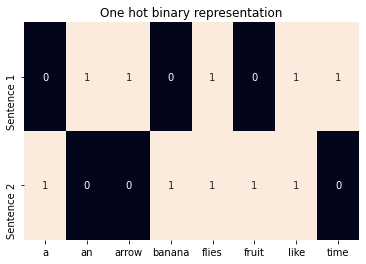

In [8]:
sns.heatmap(data.numpy(), annot=True, cbar=False,
            xticklabels=vocab, yticklabels=["Sentence 1", "Sentence 2"])
plt.title("One hot binary representation")
plt.show()

### TF Representation
Term frequency Matrix representation is a widely use technique in Information Retrievel and are actively used even today in NLP production system!, this is simple the vector sum along rows `(dim=0)` of the word matrix one hot representation. This technique measure how frequent a word is in a sentence, this is an important statistic metric to analyze.

In [9]:
print("TF sentence representation:")
print("Word to idx:", word2idx)
new_corpus = corpus # + ["Fruit flies like time flies fruit"]
data = []
for sentence in new_corpus:
    # sum sentence one hot matrix along the dim=0 (rows)
    tf_rep = get_sentence_one_hot(sentence).sum(dim=0)
    data.append(tf_rep)
    print("sentence:", sentence)
    print("TF representation:", tf_rep)
# stack as rows!
data = torch.stack(data, dim=0)

TF sentence representation:
Word to idx: {'a': 0, 'an': 1, 'arrow': 2, 'banana': 3, 'flies': 4, 'fruit': 5, 'like': 6, 'time': 7}
sentence: Time flies like an arrow
TF representation: tensor([0, 1, 1, 0, 1, 0, 1, 1])
sentence: Fruit flies like a banana
TF representation: tensor([1, 0, 0, 1, 1, 1, 1, 0])


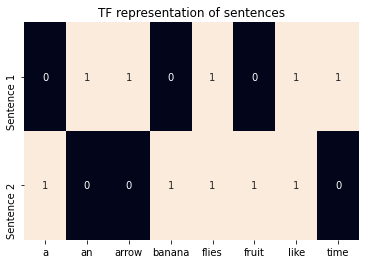

In [10]:
sns.heatmap(data, annot=True, cbar=False,
           xticklabels=vocab, yticklabels=["Sentence 1", "Sentence 2"])
plt.title("TF representation of sentences")
plt.show()

### TF-IDF Representation
The problems with TF representation is that weight words with repetition, that's tend to weight not usefull words like stopwords such as: Articles, and so on. But with TF-IDF is a heuristic that do a well weighted to words. `IDF` representation penalizes common tokens and rewards rare tokens in the vector representation $IDF(w)$ is define with respect to corpus as follows:

$$IDF(w)=\log\left(\frac{N}{n_w}\right)$$

Where $n_w$ is the number of documents that have the word $w$ and $N$ is the number of documents.

- Case 1: the word occur in every document $n_w = N$ then $IDF(w) = \log(1) = 0$ completly penalizing that word.
- Case 2: the word occur just one time in a document $IDF(w) = \log(N)$ will be the maximun value for the weight of that word.

The `TF-IDF` will be:

$$TF-IDF(w) = TF(w) \times IDF(w)$$

In [11]:
print("TF-IDF sentence representation:")
print("Word to idx:", word2idx)
new_corpus = corpus
tf, oh = [], []
for sentence in new_corpus:
    # sum sentence one hot matrix along the dim=0 (rows)
    # get tf documents score
    oh_encode = get_sentence_one_hot(sentence)
    tf_rep = oh_encode.sum(dim=0).to(dtype=torch.float32)
    tf_rep /= tf_rep.sum()
    # get one hot representation of words binary!
    oh_rep = get_sentence_collapse_one_hot(oh_encode)
    tf.append(tf_rep)
    oh.append(oh_rep)
# stack tf of each sentence as rows!
tf = torch.stack(tf, dim=0).to(dtype=torch.float32)
oh = torch.stack(oh, dim=0).sum(dim=0) # this calculate the number of documents use by each word
idf = torch.log10(len(new_corpus)/oh)
tfidf = tf * idf

TF-IDF sentence representation:
Word to idx: {'a': 0, 'an': 1, 'arrow': 2, 'banana': 3, 'flies': 4, 'fruit': 5, 'like': 6, 'time': 7}


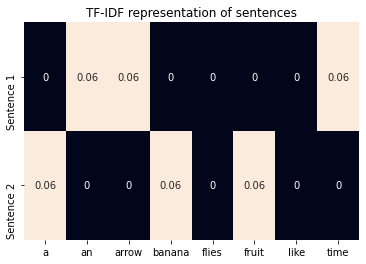

In [12]:
sns.heatmap(tfidf.numpy(), annot=True, cbar=False,
           xticklabels=vocab, yticklabels=["Sentence 1", "Sentence 2"])
plt.title("TF-IDF representation of sentences")
plt.show()

## Using SKLEARN Library to apply count-base representation

### One-Hot representation

One Hot matrix representation is not implemented in sklearn, because is not usually done in that way.  It's more common to use collapse representation

In [14]:
corpus = ["Time flies like an arrow", "fruit flies like a banana"]
vocab = list(set(word.lower() for sentence in corpus for word in sentence.split()))
word_idx = {word:idx for idx, word in enumerate(vocab)}
idx_word = {idx:word for idx, word in enumerate(vocab)}

In [15]:
print(word_idx)
print(idx_word)

{'a': 0, 'flies': 1, 'time': 2, 'like': 3, 'fruit': 4, 'arrow': 5, 'banana': 6, 'an': 7}
{0: 'a', 1: 'flies', 2: 'time', 3: 'like', 4: 'fruit', 5: 'arrow', 6: 'banana', 7: 'an'}


In [16]:
onehot_vocab = torch.eye(len(vocab))
onehot_vocab

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]])

Show the one hot representation for one word

In [17]:
onehot_vocab[word_idx["time"]] # One hot encode for the word time

tensor([0., 0., 1., 0., 0., 0., 0., 0.])

In [18]:
def encode(sentence):
    sentence_vector_idx = [word_idx[word.lower()] for word in sentence.split()]
    onehot_sentence = onehot_vocab[sentence_vector_idx]
    return onehot_sentence

In [19]:
encode("flies like an") # A 3x8 matrix for the sentence one hot encode

tensor([[0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]])

Show one hot collapse binary representation

vocab : ['an', 'arrow', 'banana', 'flies', 'fruit', 'like', 'time']
one hot representation 
tensor([[1, 1, 0, 1, 0, 1, 1],
        [0, 0, 1, 1, 1, 1, 0]])


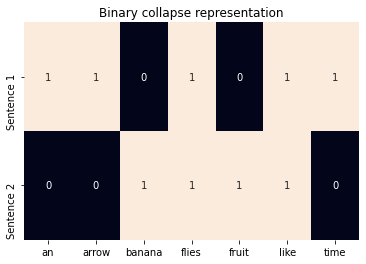

In [20]:
corpus = ["Time flies flies like an arrow",
         "Fruit flies like a banana"]
one_hot_vectorizer = CountVectorizer(binary=True)
one_hot = torch.tensor(one_hot_vectorizer.fit_transform(corpus).toarray())
vocab = one_hot_vectorizer.get_feature_names()
print("vocab : {}".format(vocab))
print("one hot representation \n{}".format(one_hot))
sns.heatmap(one_hot, annot=True,
           cbar=False, xticklabels=vocab,
           yticklabels=["Sentence 1", "Sentence 2"])
plt.title("Binary collapse representation")
plt.show()

### TF representation

vocab : ['an', 'arrow', 'banana', 'flies', 'fruit', 'like', 'time']
tf representation 
tensor([[1, 1, 0, 2, 0, 1, 1],
        [0, 0, 1, 1, 1, 1, 0]])


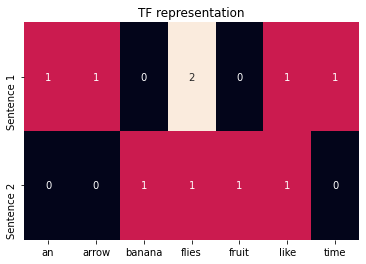

In [21]:
corpus = ["Time flies flies like an arrow",
         "Fruit flies like a banana"]
tf_vectorizer = CountVectorizer()
tf_representation = torch.tensor(tf_vectorizer.fit_transform(corpus).toarray())
vocab = tf_vectorizer.get_feature_names()
print("vocab : {}".format(vocab))
print("tf representation \n{}".format(tf_representation))
sns.heatmap(tf_representation, annot=True,
           cbar=False, xticklabels=vocab,
           yticklabels=["Sentence 1", "Sentence 2"])
plt.title("TF representation")
plt.show()

### TF-IDF representation
The Implementation of skelearn tf-idf is slightly different to the implemented before because, there are many variants to avoid numerical inestability or to normalize the matrix

vocab : ['an', 'arrow', 'banana', 'flies', 'fruit', 'like', 'time']
tfidf representation 
tensor([[0.4252, 0.4252, 0.0000, 0.6051, 0.0000, 0.3025, 0.4252],
        [0.0000, 0.0000, 0.5762, 0.4099, 0.5762, 0.4099, 0.0000]],
       dtype=torch.float64)


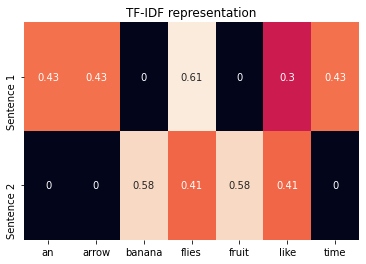

In [22]:
corpus = ["Time flies flies like an arrow",
         "Fruit flies like a banana"]

tfidf_vectorizer = TfidfVectorizer()
tfidf_representation = torch.tensor(tfidf_vectorizer.fit_transform(corpus).toarray())
vocab = tfidf_vectorizer.get_feature_names()
print("vocab : {}".format(vocab))
print("tfidf representation \n{}".format(tfidf_representation))
sns.heatmap(tfidf_representation, annot=True,
           cbar=False, xticklabels=vocab,
           yticklabels=["Sentence 1", "Sentence 2"])
plt.title("TF-IDF representation")
plt.show()

## Create a class vectorizer for tfidf, tf binarizer and tf using pytorch

In [40]:
%load_ext autoreload
%autoreload 2

from vectorizer import PytorchVectorizer # just load the vectorizer class naive implementation for learning purposes

# corpus = ["Time flies like an arrow", "Fruit flies like a banana"]
corpus = ["Time flies flies like an arrow",
         "Fruit flies like a banana"]
representer = PytorchVectorizer(corpus)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


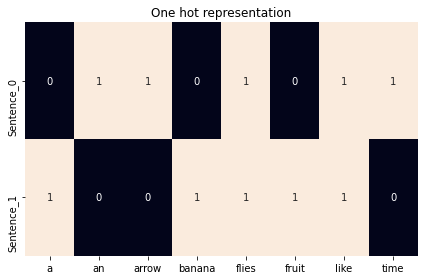

In [41]:
one_hot = representer.one_hot_reprensentation()
representer.plot(one_hot, "One hot representation")

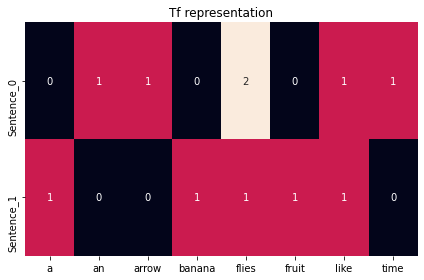

In [42]:
tf_rep = representer.tf_representation()
representer.plot(tf_rep, "Tf representation")

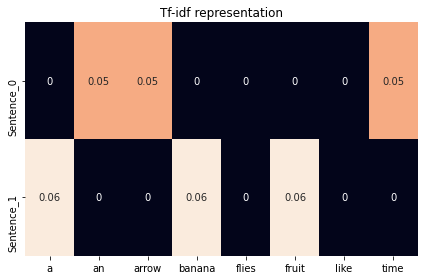

In [43]:
tfidf_rep = representer.tfidf_representation()
representer.plot(tfidf_rep, "Tf-idf representation")